In [30]:
import numpy as np 
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import skfda
from Functions import *
from sklearn.model_selection import train_test_split
from skfda.ml.regression import LinearRegression
from skfda.representation.basis import BSplineBasis
from skfda.ml.regression import KNeighborsRegressor
from skfda.misc.kernels import uniform
from skfda.preprocessing.smoothing import KernelSmoother
from skfda.representation.basis import FDataBasis
from skfda.exploratory.visualization import Boxplot
from skfda.preprocessing.missing import MissingValuesInterpolation
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from matplotlib import cm
import seaborn as sns
from skfda.exploratory.depth import IntegratedDepth, ModifiedBandDepth


## Data preprocessing - Output processing

In [9]:
# IDs that meet the research criteria
data_used = pd.read_excel('ethylene_used.xlsx')
ID = list(set(data_used['ID']))

# - the time interval we focused on
Tmin = 0; Tmax = 300
Grids = np.arange(Tmin, Tmax+1, 1)

'''Call the defined function for interpolation'''
df_Curves = format_Curves(data_used, ID, Grids)
df_Curves.head()

,T0,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T291,T292,T293,T294,T295,T296,T297,T298,T299,T300
0,0.348684,0.348684,0.348684,0.348684,0.348684,0.348684,0.350776,0.353757,0.356737,0.359717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.302632,0.302632,0.302632,0.302632,0.302632,0.302632,0.303910,0.305731,0.307553,0.309374,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.328947,0.328947,0.328947,0.328947,0.328947,0.328947,0.330691,0.333174,0.335658,0.338141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.182081,0.182081,0.182081,0.182081,0.182081,0.182081,0.182081,0.182081,0.182081,0.182081,...,0.071646,0.071369,0.071091,0.070813,0.070536,0.070258,0.069980,0.069703,0.069425,0.069198
4,0.287791,0.287791,0.287791,0.287791,0.287791,0.288127,0.291716,0.295305,0.298894,0.302483,...,0.462190,0.461841,0.461493,0.461144,0.460795,0.460447,0.460098,0.459750,0.459401,0.458903


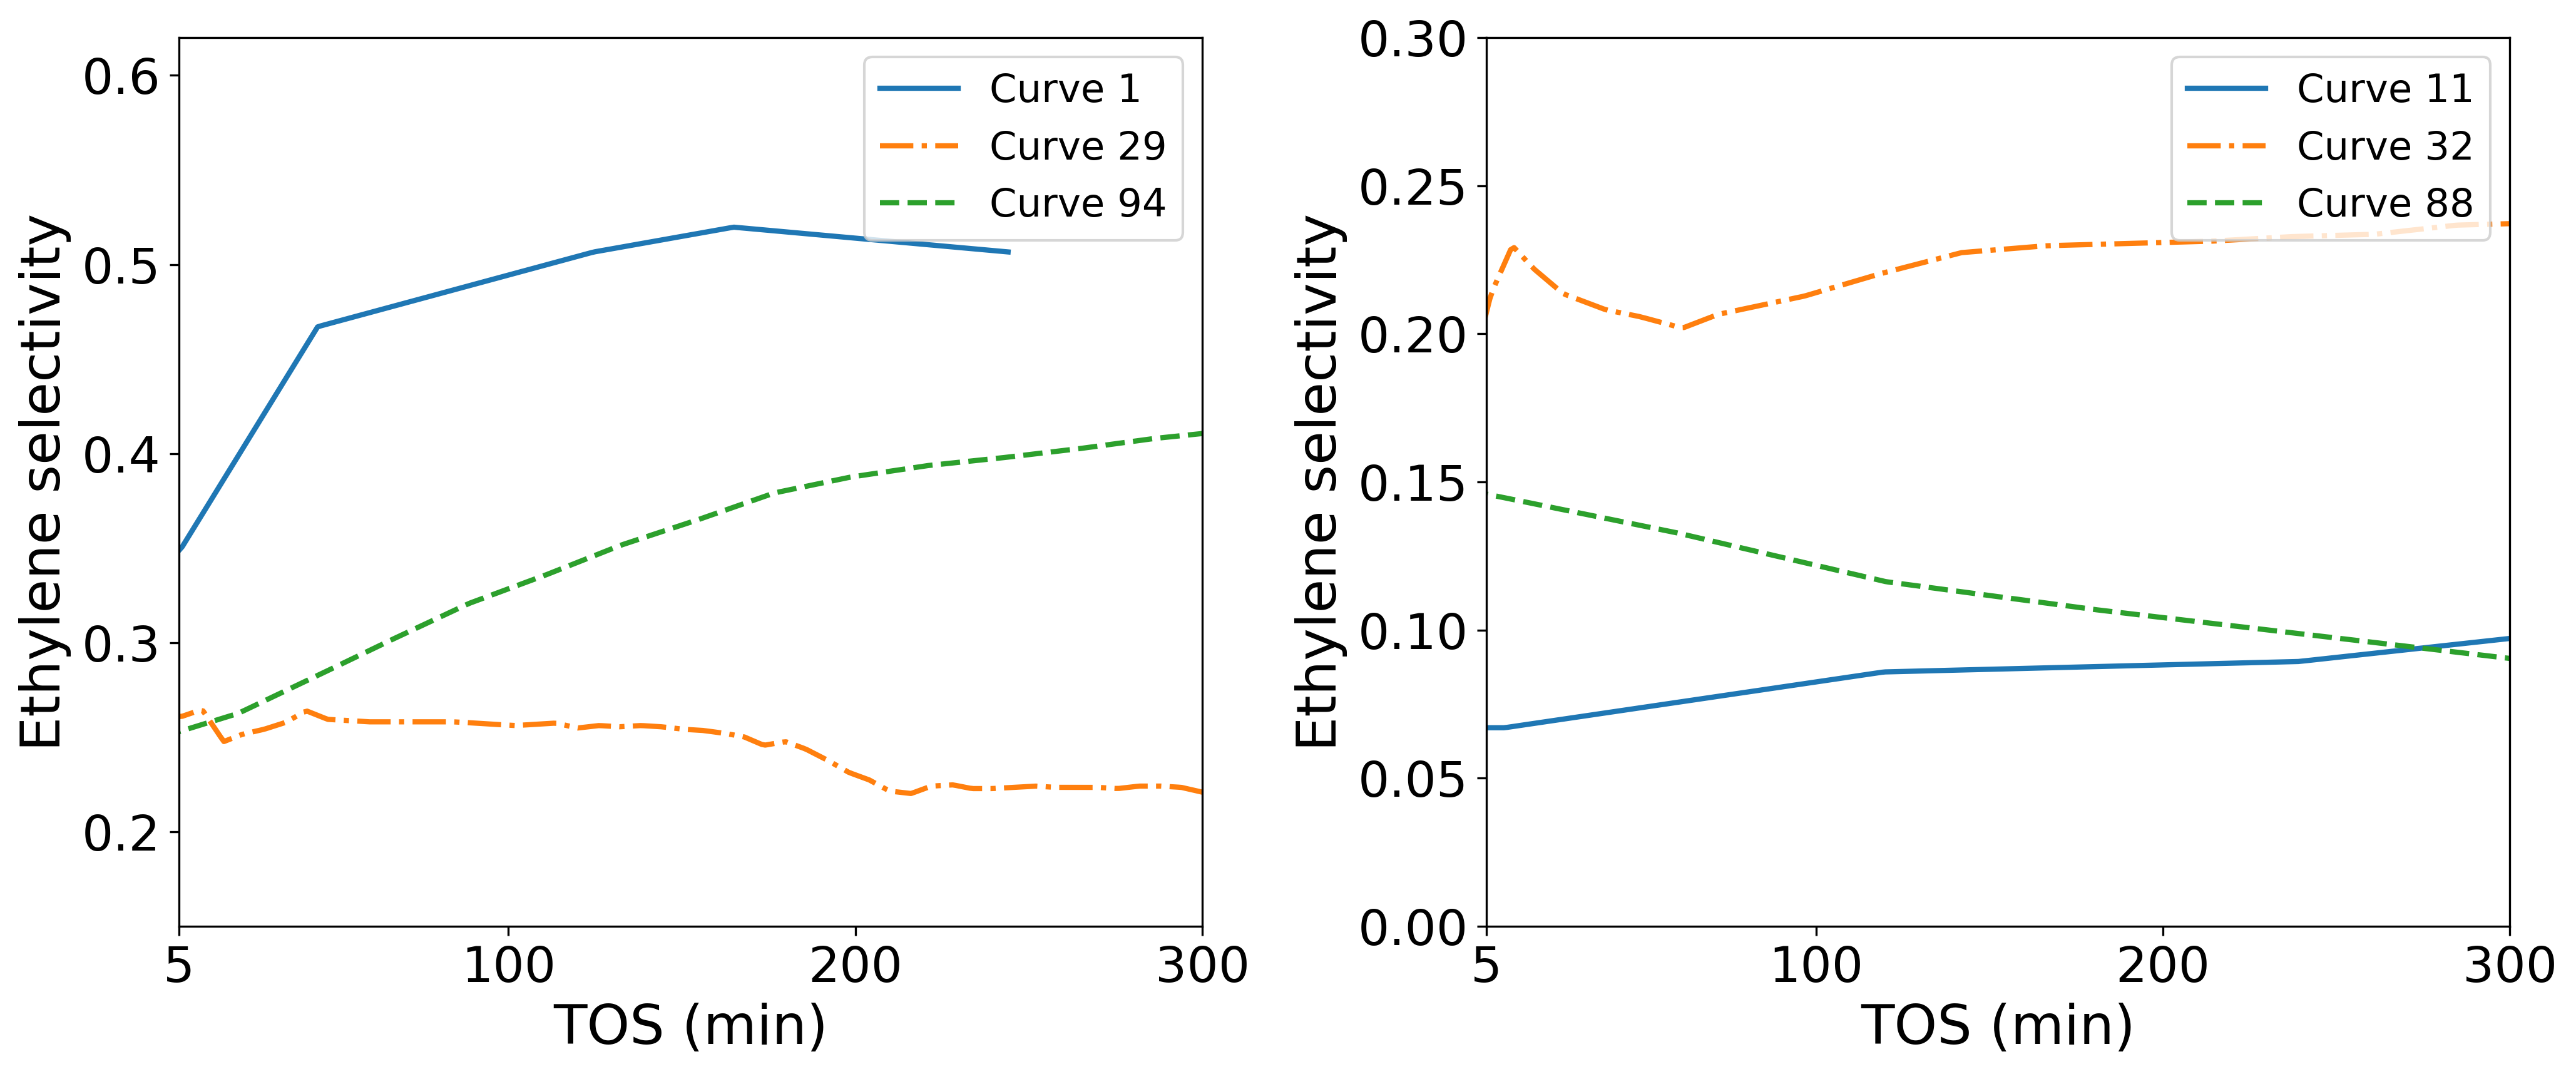

In [13]:
curves_show_id = [0, 28, 93, 10, 31, 87]

plt.rc('font', size=16)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
f_data = df_Curves
axs = axs.flatten()
j=0
for i in range(2):
    ax=axs[i]
    curves = f_data.iloc[curves_show_id[3*i], :].tolist()
    curves_1 = f_data.iloc[curves_show_id[3*i+1], :].tolist()
    curves_2 = f_data.iloc[curves_show_id[3*i+2], :].tolist()
    ax.plot(range(len(curves)), curves, linewidth=2, ls='-', label=f'Curve {curves_show_id[3*i]+1}')
    ax.plot(range(len(curves)), curves_1, linewidth=2, ls='-.', label=f'Curve {curves_show_id[3*i+1]+1}')
    ax.plot(range(len(curves)), curves_2, linewidth=2, ls='--', label=f'Curve {curves_show_id[3*i+2]+1}')
    if i==0:
        ax.set_ylim(0.15,0.62)
    else:
        ax.set_ylim(0,0.3)
    ax.legend(fontsize=15)
    ax.set_xlim(5, 300)
    ax.set_xticks([5, 100, 200, 300])
    ax.set_xlabel('TOS (min)', fontsize=21)
    ax.set_ylabel('Ethylene selectivity', fontsize=21)
    ax.tick_params(axis='both', which='major', labelsize=19)
    ax.legend(fontsize=15,loc='upper right')
plt.tight_layout()
plt.savefig("figs/6_curves.png")
plt.show()

## Outlier handling

In [14]:
df_Curves_copy = df_Curves.copy()
# Calculate the first-order derivative
df_diff = df_Curves_copy.diff(axis=1)
# Set the threshold
threshold = 2 * df_diff.std().mean()  # For example, use twice the mean standard deviation as the threshold

# Identify outliers
outliers = np.abs(df_diff) > threshold

# Mark curves containing outlier values
outlier_indices = outliers.any(axis=1)
print(f"Identified {len(outlier_indices[outlier_indices])} curves with outlier points")
# Replace outlier points with NaN
df_Curves_copy[outliers] = np.nan
# Calculate the number of curves containing outlier values
num_outlier_curves = sum(outlier_indices)

Identified 30 curves with outlier points


In [15]:
df_Curves = df_Curves_copy

In [16]:
## Format adjustment
# Set the time steps
data_tpts = Grids
# Set the response variable y
data_y = df_Curves.reset_index(drop=True)
data_y[data_y < 0] = np.nan

In [17]:
## Kernel Smoother
data_y_f = skfda.FDataGrid(
    data_matrix=data_y,
    grid_points=data_tpts)
nan_interp = MissingValuesInterpolation()
data_y_f = nan_interp.fit_transform(data_y_f)

fd_os = KernelSmoother(
    kernel_estimator=NadarayaWatsonHatMatrix(bandwidth=6, kernel=uniform),
).fit_transform(data_y_f)
data_y_kns = pd.DataFrame(fd_os.data_matrix.reshape(-1,len((fd_os.data_matrix[0]))),columns=data_tpts)

In [18]:
data_y = data_y_kns

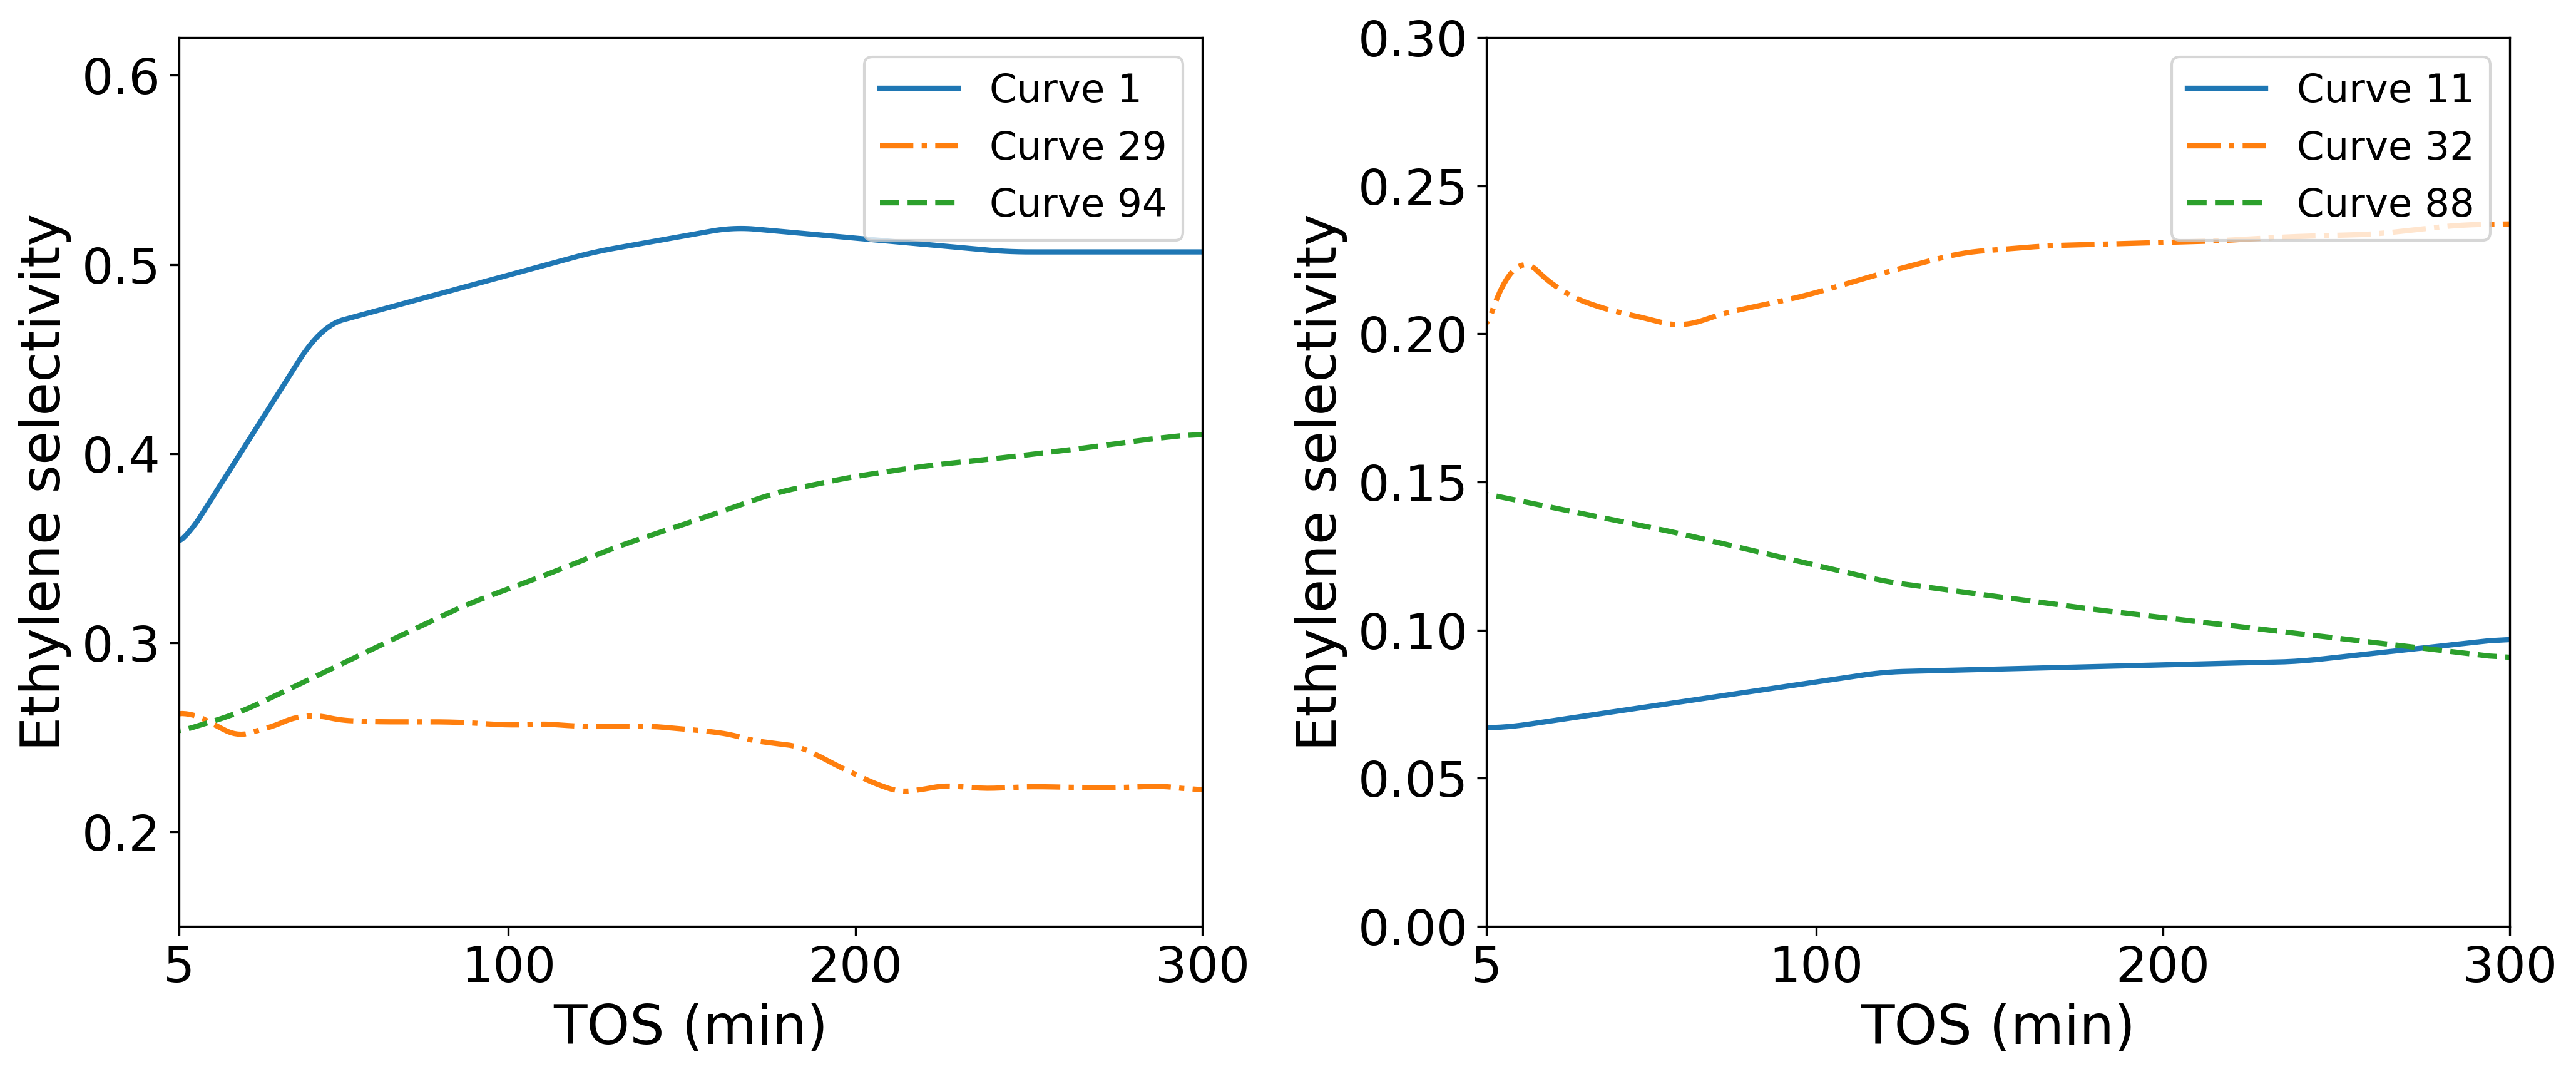

In [19]:
curves_show_id = [0, 28, 93, 10, 31, 87]

plt.rc('font', size=16)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
f_data = data_y
axs = axs.flatten()
j=0
for i in range(2):
    ax=axs[i]
    curves = f_data.iloc[curves_show_id[3*i], :].tolist()
    curves_1 = f_data.iloc[curves_show_id[3*i+1], :].tolist()
    curves_2 = f_data.iloc[curves_show_id[3*i+2], :].tolist()
    ax.plot(range(len(curves)), curves, linewidth=2, ls='-', label=f'Curve {curves_show_id[3*i]+1}')
    ax.plot(range(len(curves)), curves_1, linewidth=2, ls='-.', label=f'Curve {curves_show_id[3*i+1]+1}')
    ax.plot(range(len(curves)), curves_2, linewidth=2, ls='--', label=f'Curve {curves_show_id[3*i+2]+1}')
    if i==0:
        ax.set_ylim(0.15,0.62)
    else:
        ax.set_ylim(0,0.3)
    ax.legend(fontsize=15)
    ax.set_xlim(5, 300)
    ax.set_xticks([5, 100, 200, 300])
    ax.set_xlabel('TOS (min)', fontsize=21)
    ax.set_ylabel('Ethylene selectivity', fontsize=21)
    ax.tick_params(axis='both', which='major', labelsize=19)
    ax.legend(fontsize=15,loc='upper right')
plt.tight_layout()
plt.savefig("figs/6_curves_d.png")
plt.show()

## Data preprocessing - Input variable processing

In [24]:
X_name = ['Modification','AS','A/T','FDSi','Largest Ring sizes','MDa',
          'MDb','MDc','Mdi','CD','crystal size(μm)','reaction temp(°C)',
          'WHSV(h-1)']
cla_name = ['Modification', 'AS', 'Largest Ring sizes', 'CD']
num_name = [n for n in X_name if n not in cla_name]

X_df = data_used.drop_duplicates(subset='ID', keep='first')
data_x = X_df[X_name].reset_index(drop=True)
data_x.head()

,Modification,AS,A/T,FDSi,Largest Ring sizes,MDa,MDb,MDc,Mdi,CD,crystal size(μm),reaction temp(°C),WHSV(h-1)
0,0,0,0.080000,15.1,8,3.72,3.72,3.72,7.37,3,4.0,350,0.67
1,0,0,0.120000,14.6,8,3.75,3.75,4.10,8.82,3,2.5,350,0.67
2,0,0,0.110000,15.0,8,4.04,4.04,4.04,10.67,3,5.0,350,0.67
3,0,1,0.136986,16.1,8,3.42,3.42,3.42,7.04,3,0.1,350,0.67
4,0,1,0.133333,16.1,8,3.42,3.42,3.42,7.04,3,1.1,350,0.67


In [26]:
X_name = ['ZEOTYPE','Modification','AS','A/T','FDSi','Largest Ring sizes','MDa',
          'MDb','MDc','Mdi','CD','crystal size(μm)','reaction temp(°C)',
          'WHSV(h-1)']
X_df = data_used.drop_duplicates(subset='ID', keep='first')
data_x = X_df[X_name].reset_index(drop=True)
data_x_ac = data_x

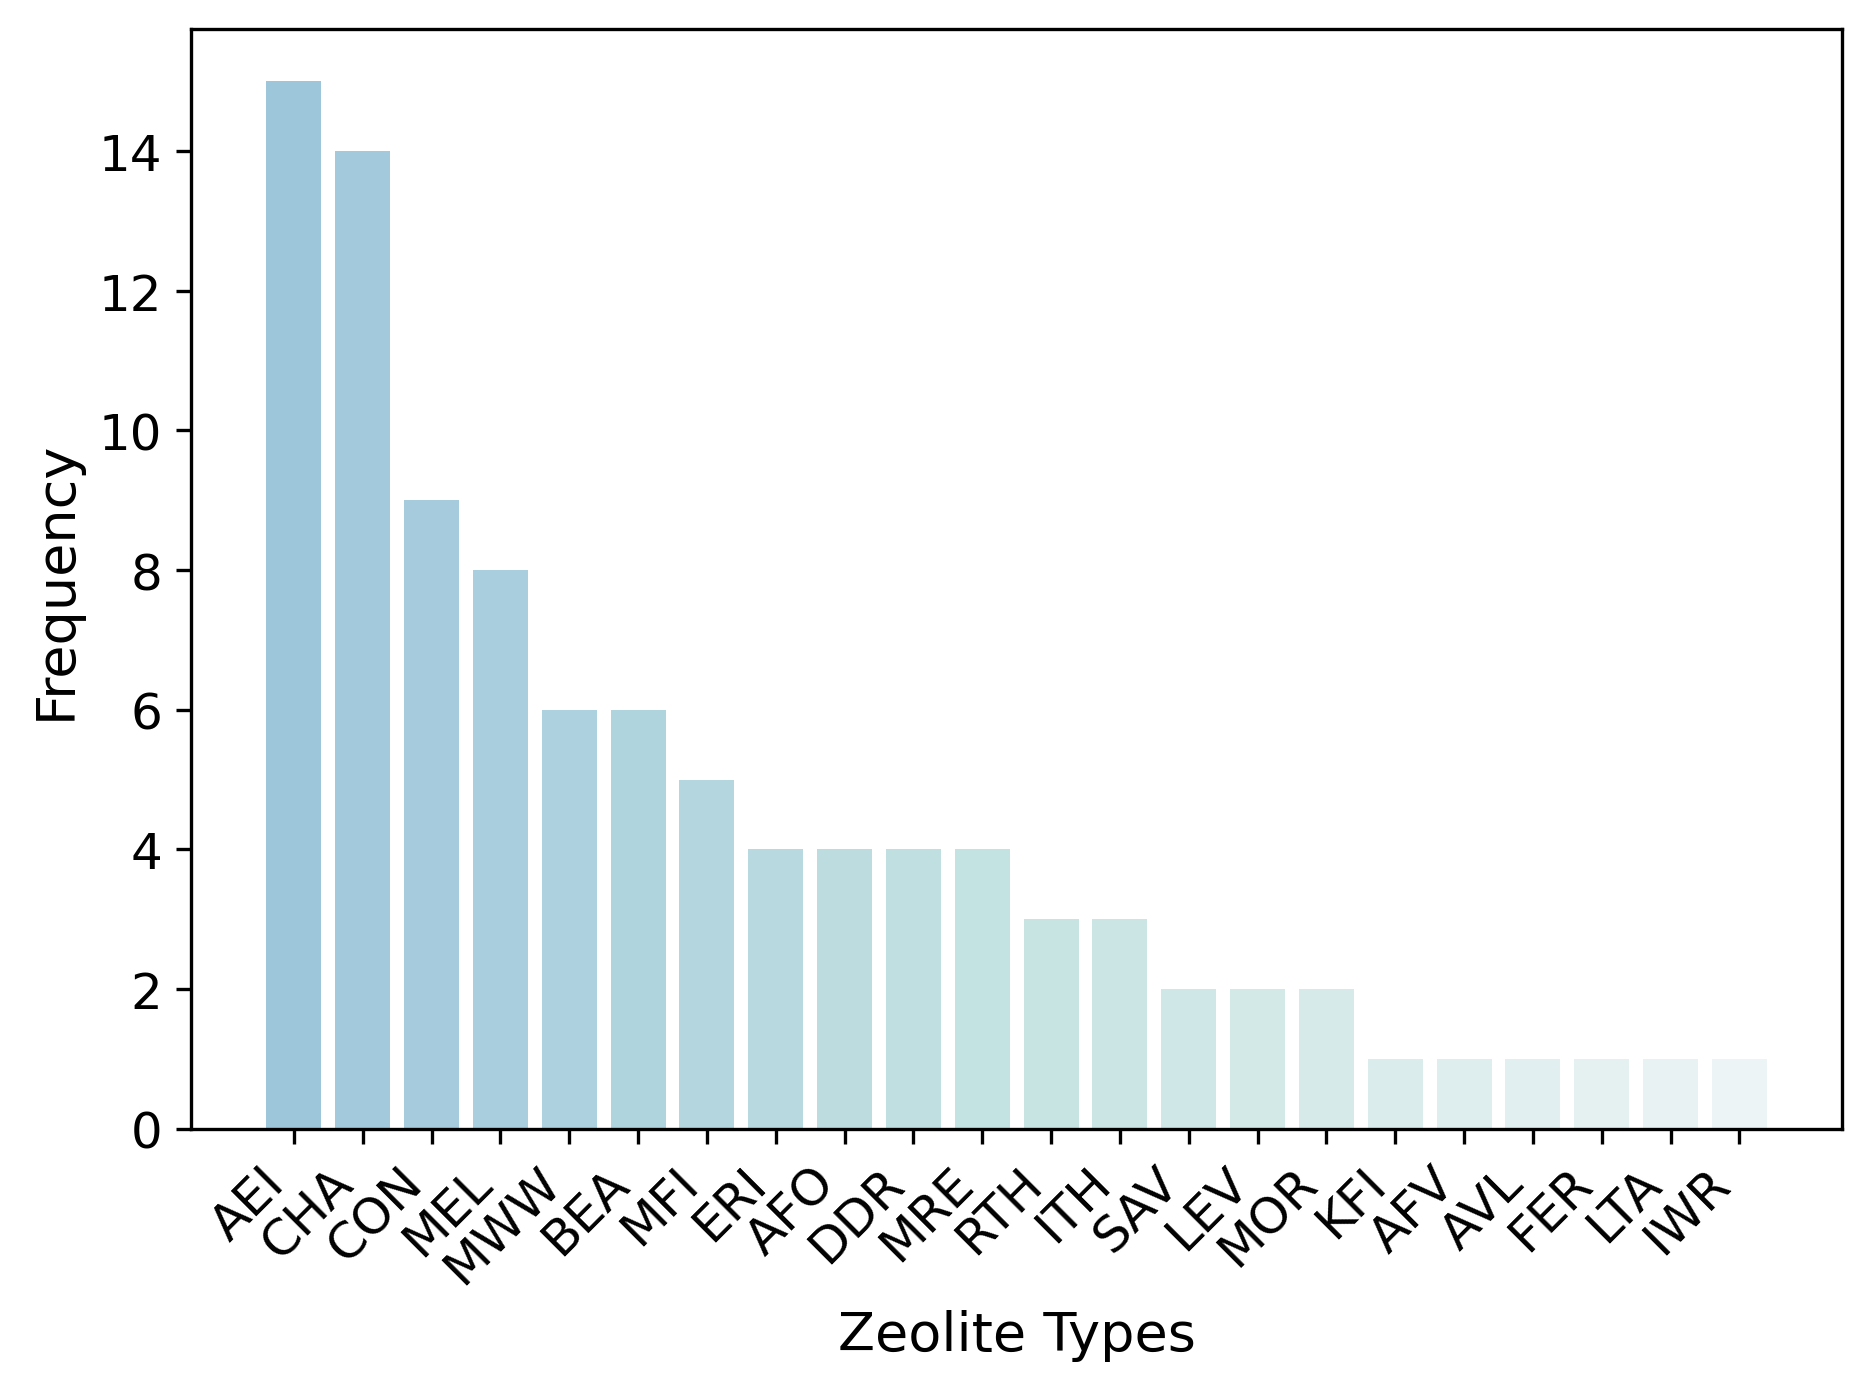

In [27]:
## Zeolite Type Chart
zeotype_data = data_x_ac['ZEOTYPE'].tolist()
# Calculate the frequency of each category
counts = Counter(zeotype_data)

# Get the category labels and their corresponding frequency values
labels, values = zip(*counts.items())

# Sort the labels and their values by frequency in descending order
sorted_labels_values = sorted(zip(labels, values), key=lambda x: x[1], reverse=True)
labels_sorted, values_sorted = zip(*sorted_labels_values)

# Create a gradient color map
cmap = LinearSegmentedColormap.from_list("mycmap", [(0, "#9EC6DB"),(0.5,"#C5E3E2"), (1, "#EDF4F5")])

matplotlib.rcParams['font.size'] = 12
# Create a new figure
fig, ax = plt.subplots(dpi=300)

# Plot the bar chart using the color map
bars = ax.bar(labels_sorted, values_sorted, color=cmap(np.linspace(0, 1, len(values_sorted))))

# Optional: Add a title and axis labels to the chart
ax.set_xlabel('Zeolite Types', fontsize=13)
ax.set_ylabel('Frequency', fontsize=13)

# Rotate the x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

# Display the chart
plt.tight_layout()  # Automatically adjust subplot parameters to fill the entire image area
# Save the chart as a PNG file
plt.savefig('figs/Frequency.png')
plt.show()

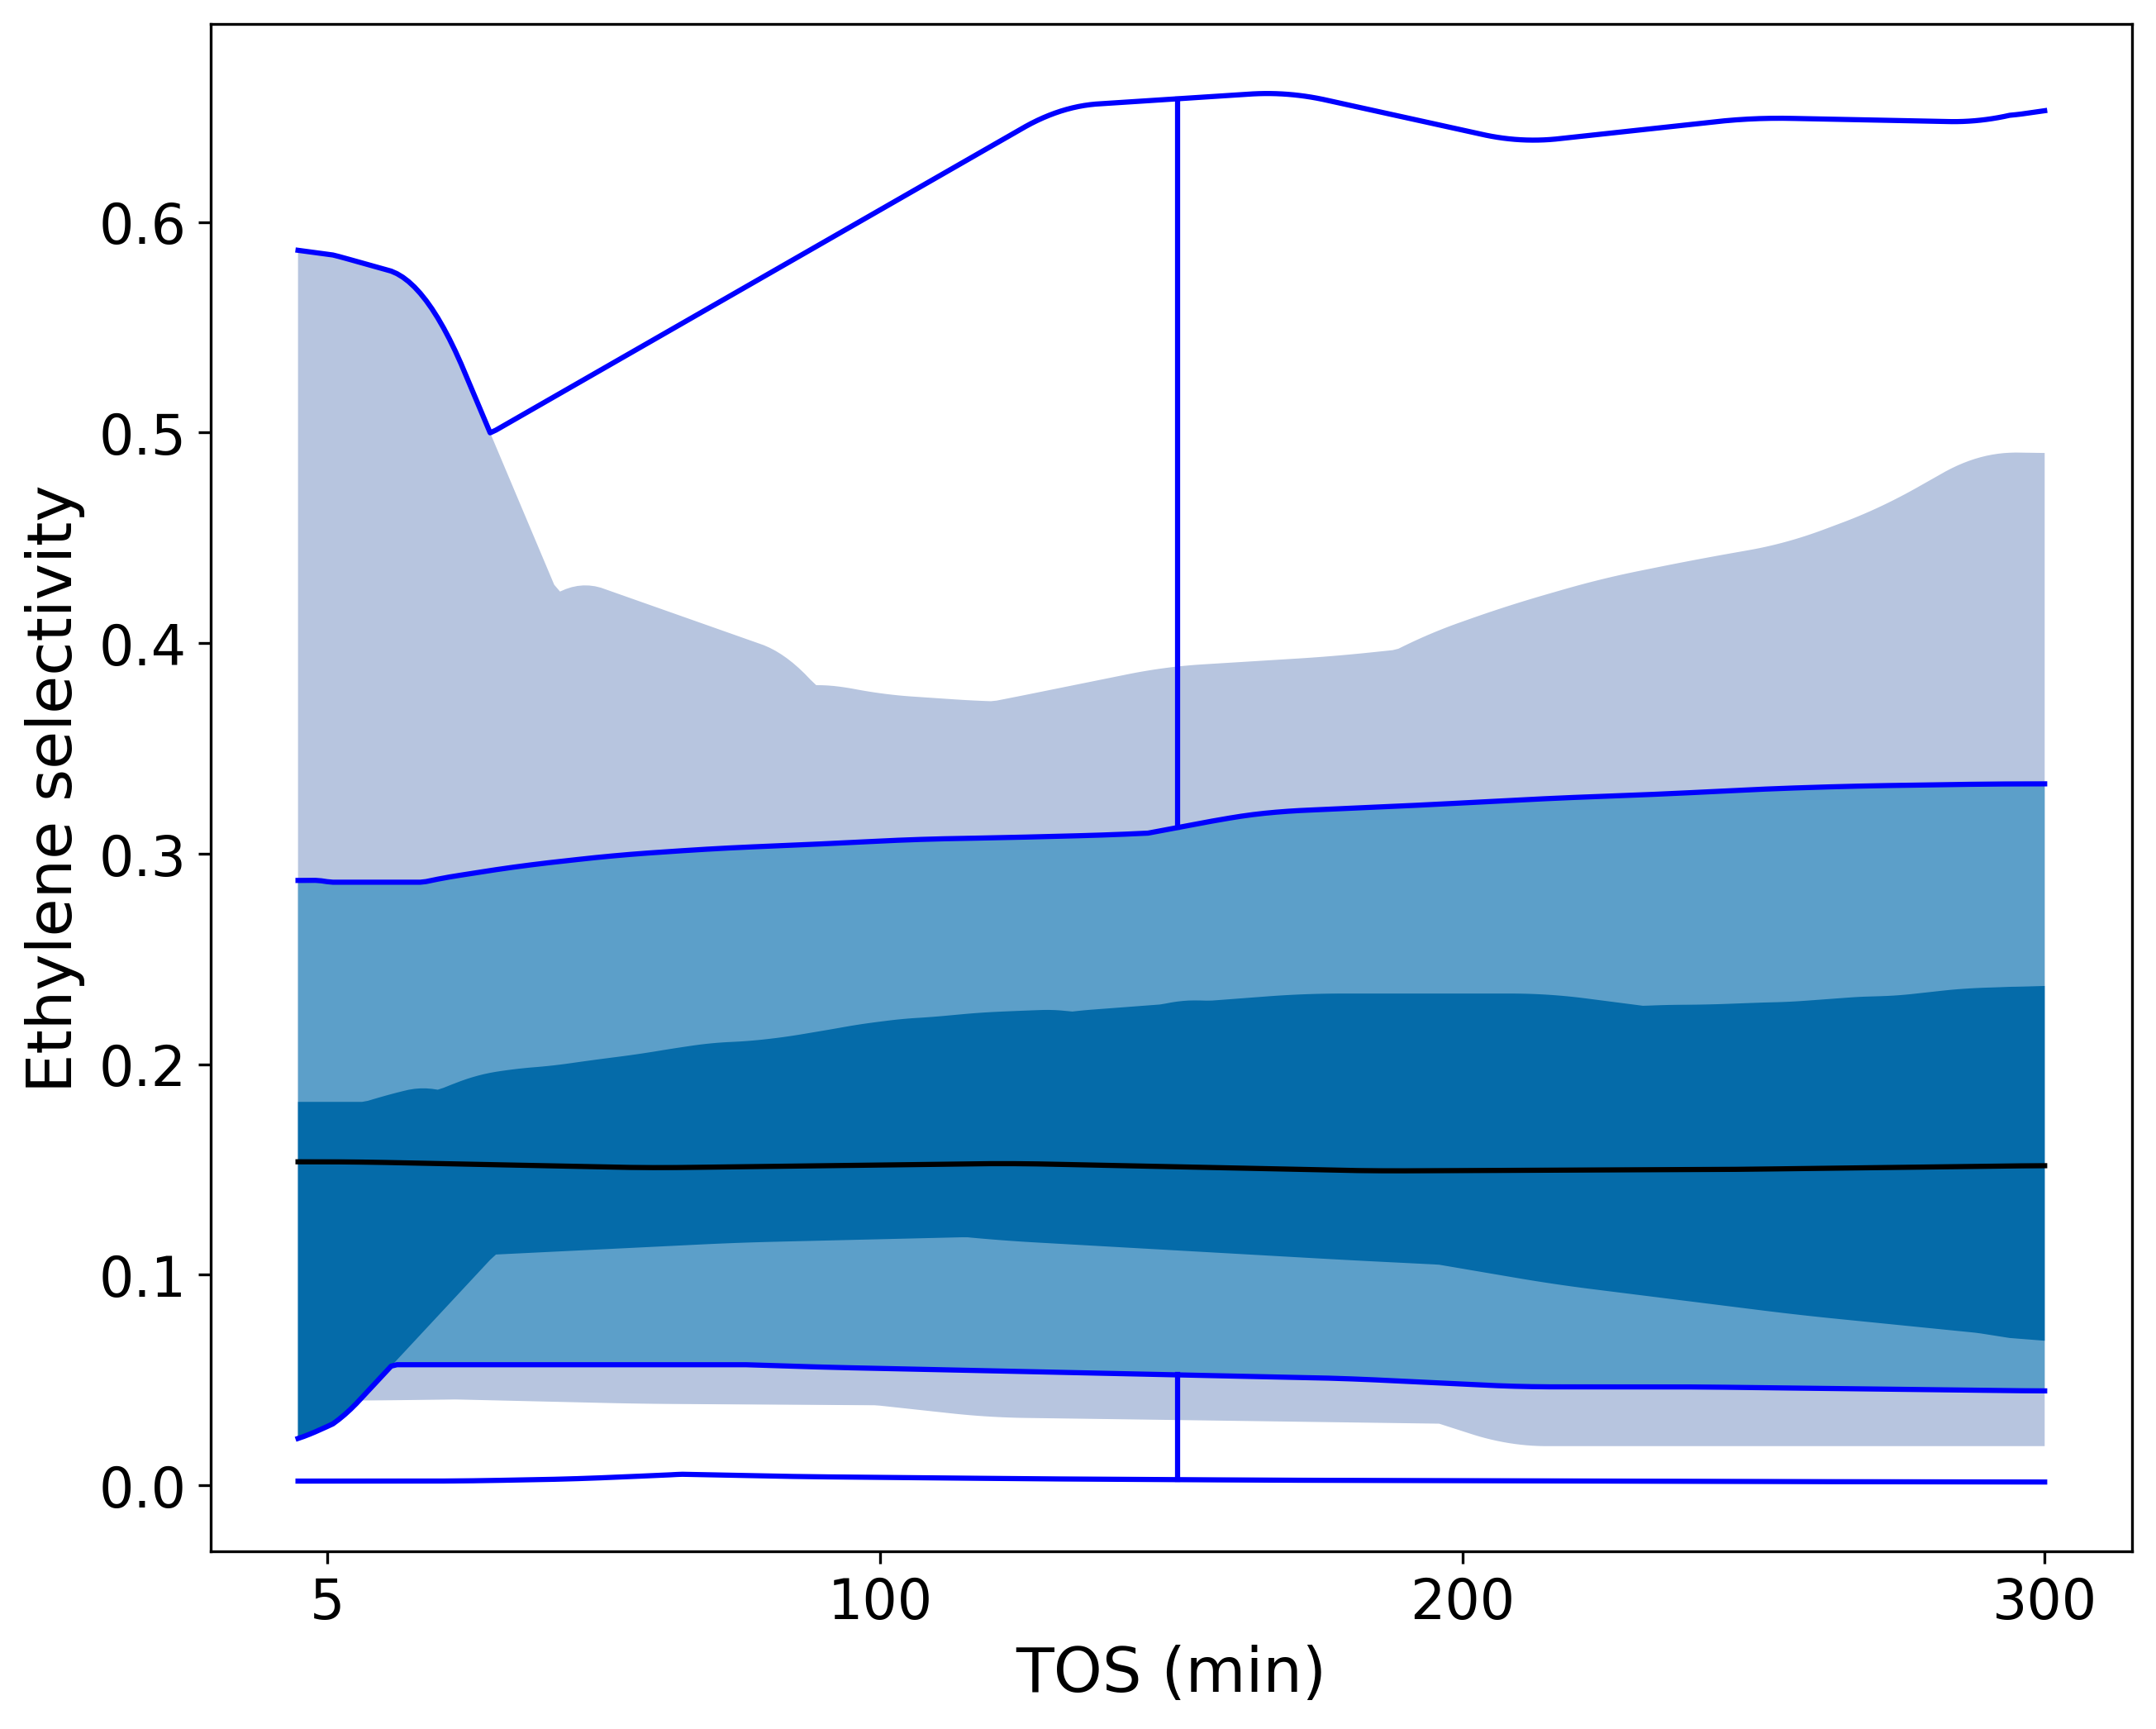

In [31]:
# Use the 'Blues' colormap, which is a gradient from light blue to dark blue
cmap = cm.PuBu
# cmap = cm.Wistia

fig = plt.figure(figsize=(10, 8), dpi=300)
# Create a Boxplot object
boxplot = Boxplot(fd_os, depth_method=IntegratedDepth(), prob=[0.75, 0.5, 0.25], fig=fig)
boxplot.colormap = cmap
boxplot.plot()
# Since Boxplot automatically creates axis objects, we need to retrieve them from the fig object
ax = fig.axes[0]  # Get the first (and only) axis object
# Set the x-axis and y-axis labels
ax.set_xticks([5, 100, 200, 300])
ax.set_xlabel('TOS (min)', fontsize=18)  # Set the x-axis label and font size
ax.set_ylabel('Ethylene selectivity', fontsize=18)  # Set the y-axis label and font size
ax.tick_params(axis='both', which='major', labelsize=16)  # Adjust the tick label font size
plt.savefig('figs/Box_plot.png')
# Display the plot
plt.show()

In [34]:
row_means = data_y.apply(np.mean, axis=1)
data_x_ac['se_mean'] = row_means
data_x_ac.to_csv('data_x_ac.csv', index=False)

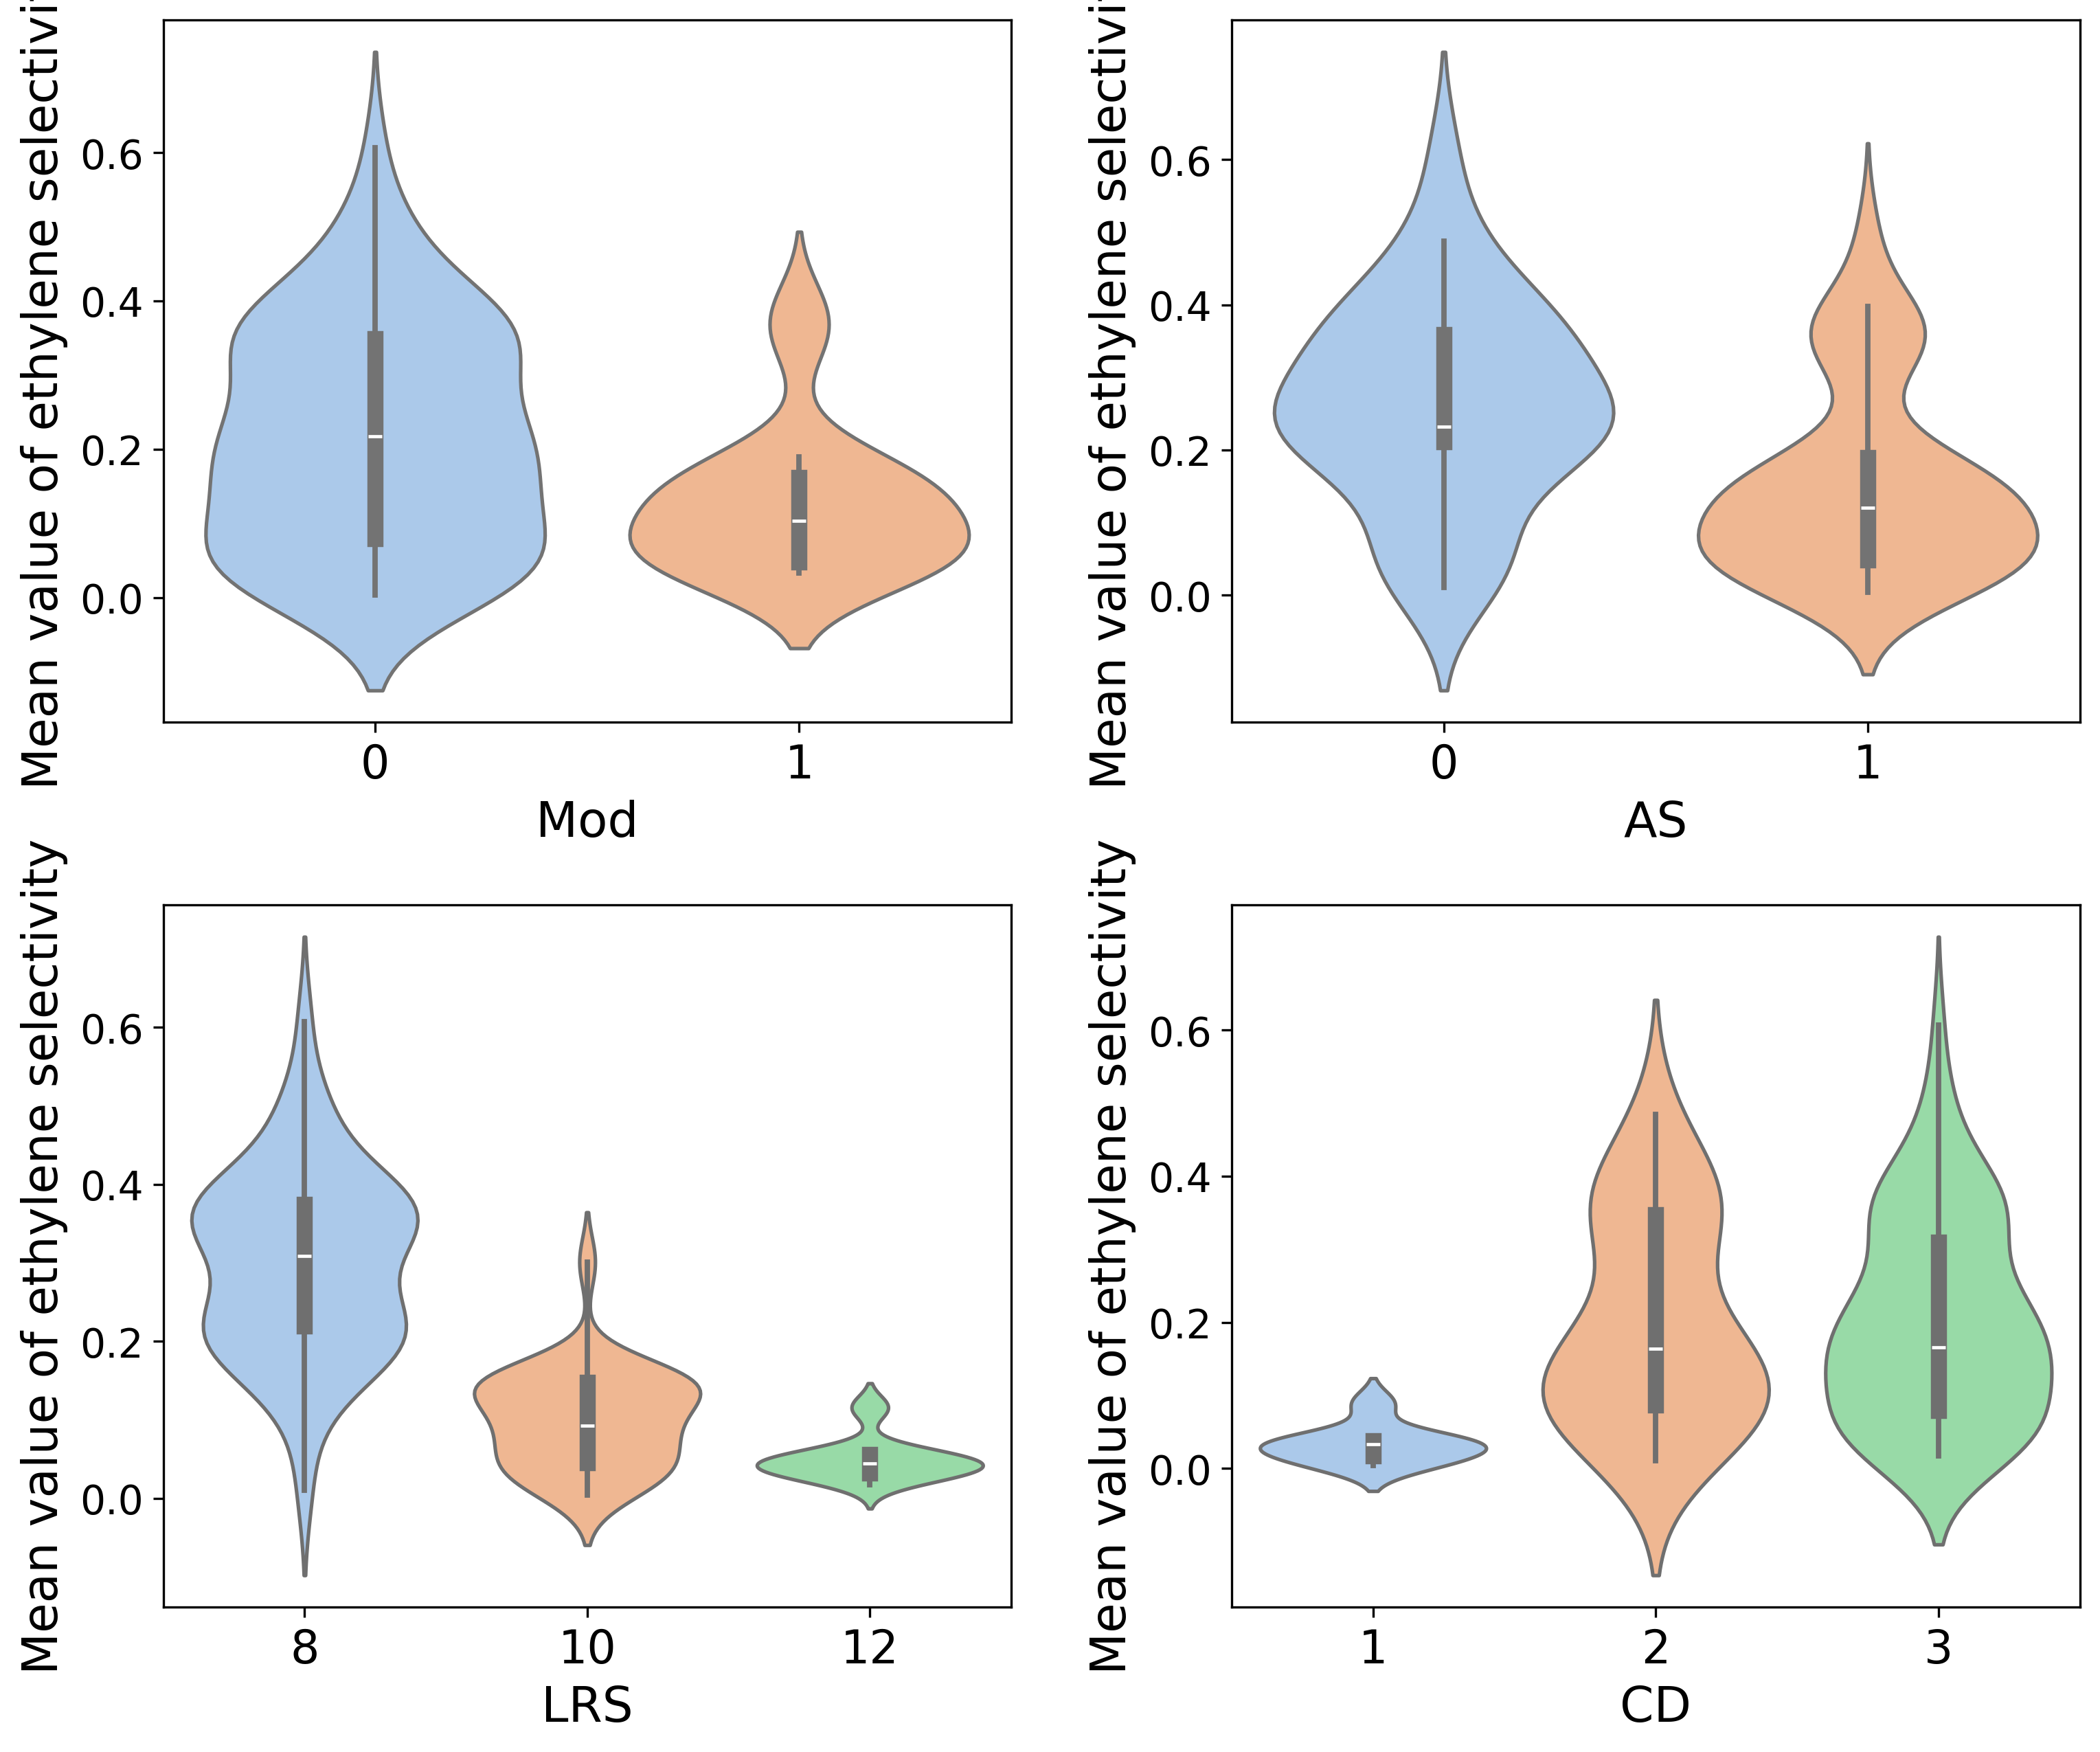

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
axs = axs.flatten()
columns = ['Modification', 'AS', 'Largest Ring sizes', 'CD']
new_x_labels = ['Mod', 'AS', 'LRS', 'CD']
palette = 'pastel'
for i, col in enumerate(columns):
    sns.violinplot(x=col, y='se_mean', data=data_x_ac, ax=axs[i], palette=palette)
    axs[i].set_xlabel(new_x_labels[i], fontsize=17)
    axs[i].set_ylabel('Mean value of ethylene selectivity', fontsize=17)
    axs[i].set_xticks(axs[i].get_xticks())
    axs[i].set_xticklabels(axs[i].get_xticklabels(), fontsize=16)
    axs[i].tick_params(axis='y', labelsize=14)

plt.subplots_adjust(hspace=0.26,wspace=0.26)
plt.savefig('figs/violinplot.png')
plt.show()